In [1]:
# typical init stuff and TODO list :)

import re
from functools import partial
import numpy as np
from numpy.random import rand, exponential, normal
from uncertainties import ufloat
import scipy as sc
import scipy.constants as const
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from datetime import datetime
import pandas as pd
import allantools as at

kgu = const.u
kb = const.k
c = const.c
e = const.e
eVJ = const.physical_constants["electron volt-joule relationship"][0]
pi2 = 2*np.pi
color = plt.cm.rainbow(np.linspace(0.8, 1, 10))

%load_ext autoreload
%autoreload 2

from fticr_toolkit import ideal_trap_physics as itp
from fticr_toolkit import systematics as sys
from IPython.display import Image

# TODO: make everythink compatible in units: use m and not mm, use J not eV,
# make constants /conversions available: tp.kb / tp.kb_err, tp.kgu / tp.kgu_err
# TODO: merge ideal_trap_physics and systematics to trap_physics and add this also there...
# TODO: split this delphi function into a more smaller functions, for code quality :)


# Starep Stability

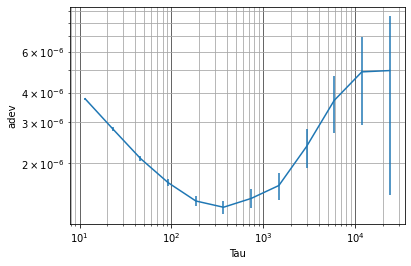

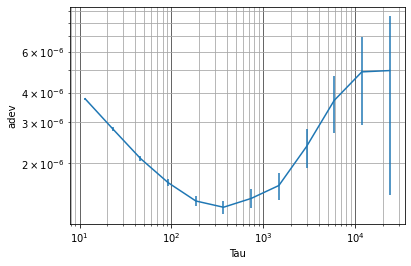

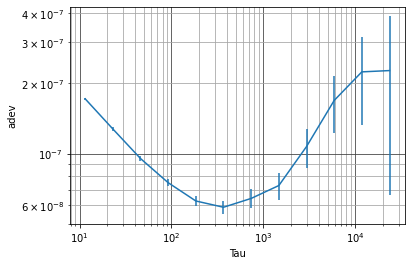

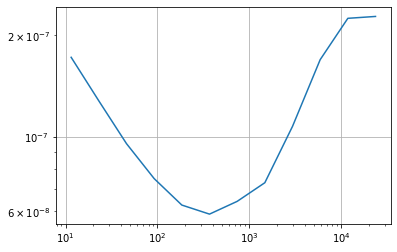

In [2]:
df = pd.read_csv("double_HV_channel_20200721_stripped.csv", header=0)
#print(df)
df.time = pd.to_datetime(df.time)
#print(df)
df["sec"] = (df.time - df.time.min()).dt.total_seconds()
#print(df)
dsec = (df.sec.to_numpy()[1:] - df.sec.to_numpy()[:-1]).mean()
#print(dsec)
df["v_norm"] = df.voltage / df.voltage.mean()
df["v_flat"] = df.voltage - np.around(df.voltage.mean(), 6)

a = at.Dataset(df.voltage.to_numpy(), rate=1/dsec, data_type="freq")#, taus=df["sec"])
a.compute("adev")
b = at.Plot()
b.plot(a,errorbars=True, grid=True)
b.show()

a = at.Dataset(df.v_flat.to_numpy(), rate=1/dsec, data_type="freq")#, taus=df["sec"])
a.compute("adev")
b = at.Plot()
b.plot(a,errorbars=True, grid=True)
b.show()

a = at.Dataset(df.v_norm.to_numpy(), rate=1/dsec, data_type="freq")#, taus=df["sec"])
a.compute("adev")
b = at.Plot()
b.plot(a,errorbars=True, grid=True)
b.show()

(t2, ad, ade, adn) = at.adev(df.v_norm.to_numpy(), rate=1/dsec, data_type="freq")#, taus=df["sec"])  # Compute the overlapping ADEV
plt.loglog(t2, ad)
plt.grid("both")
plt.show()

In [3]:
ion = '172Yb43+'
nu_res = 501e3

m, q = re.findall(r'\d+', ion)
m = int(m)
q = int(q)

In [4]:
U0 = itp.U0(q, m, nu_res)
print(U0)

-13.730055549284835


In [5]:
# starep_stability over measurement times
meas_time = 70 # Tevol
break_time = 25 # cool, prep, Tref, cool, prep
step_time = meas_time + break_time

meas_vals = int(meas_time/dsec)
break_vals = int(break_time/dsec)
print(meas_vals, break_vals)
cols = meas_vals + break_vals

6 2


In [6]:
vnorm_clip = df.v_flat.to_numpy()
appendix = len(vnorm_clip)%cols
vnorm_clip = vnorm_clip[:-appendix]

v_norm_re = vnorm_clip.reshape((-1, cols))
print(v_norm_re)

[[-1.10000000e-05 -6.00000000e-06 -1.20000000e-05 ... -1.30000000e-05
  -9.00000000e-06 -8.00000000e-06]
 [-5.00000000e-06 -5.00000000e-06 -3.00000000e-06 ... -1.30000000e-05
  -4.00000000e-06 -9.99999997e-07]
 [-1.00000000e-05 -1.10000000e-05 -1.50000000e-05 ... -8.00000000e-06
  -5.00000000e-06 -7.00000000e-06]
 ...
 [ 1.00000000e-05  1.10000000e-05  1.00000000e-05 ...  1.10000000e-05
   1.20000000e-05  1.00000000e-05]
 [ 3.00000000e-06  1.50000000e-05  9.00000000e-06 ...  1.40000000e-05
   8.00000000e-06  8.00000000e-06]
 [ 4.00000000e-06  6.00000000e-06  6.00000000e-06 ...  5.00000000e-06
   8.00000000e-06  1.40000000e-05]]


In [7]:
vnorm_meas = v_norm_re[:,:meas_vals]
print(vnorm_meas)

[[-1.1e-05 -6.0e-06 -1.2e-05 -9.0e-06 -1.2e-05 -1.3e-05]
 [-5.0e-06 -5.0e-06 -3.0e-06 -6.0e-06 -1.2e-05 -1.3e-05]
 [-1.0e-05 -1.1e-05 -1.5e-05 -1.0e-05 -1.2e-05 -8.0e-06]
 ...
 [ 1.0e-05  1.1e-05  1.0e-05  5.0e-06  9.0e-06  1.1e-05]
 [ 3.0e-06  1.5e-05  9.0e-06  1.1e-05  2.0e-06  1.4e-05]
 [ 4.0e-06  6.0e-06  6.0e-06  5.0e-06  9.0e-06  5.0e-06]]


In [8]:
mean_vnorm_meas = np.mean(vnorm_meas, axis=1)
print(mean_vnorm_meas)

[-1.05000000e-05 -7.33333333e-06 -1.10000000e-05 -1.01666667e-05
 -6.16666667e-06 -7.66666667e-06 -7.00000000e-06 -8.00000000e-06
 -3.83333333e-06 -4.83333333e-06 -3.50000000e-06 -5.16666666e-06
 -3.50000000e-06 -3.33333331e-07 -2.50000000e-06  1.77635684e-15
 -1.16666667e-06 -4.66666667e-06 -1.33333333e-06 -1.66666667e-06
 -3.66666667e-06  3.33333334e-07  2.00000000e-06 -3.33333332e-07
 -2.50000000e-06 -4.99999998e-07 -2.16666667e-06 -8.33333332e-07
  1.77635684e-15  5.00000001e-07  1.33333333e-06  3.00000000e-06
  5.16666667e-06  5.00000000e-06  3.16666667e-06  5.66666667e-06
  5.16666667e-06  4.16666667e-06  2.66666667e-06  5.16666667e-06
  5.50000000e-06  8.33333333e-06  7.16666667e-06  5.33333333e-06
  7.50000000e-06  6.00000000e-06  3.00000000e-06  5.50000000e-06
  5.16666667e-06  5.00000000e-06 -1.66666666e-07  3.50000000e-06
  5.16666667e-06  2.50000000e-06  6.33333333e-06  3.66666667e-06
  4.00000000e-06  8.66666667e-06  2.83333333e-06  5.50000000e-06
  5.83333333e-06  4.00000

935
24.67361111111111


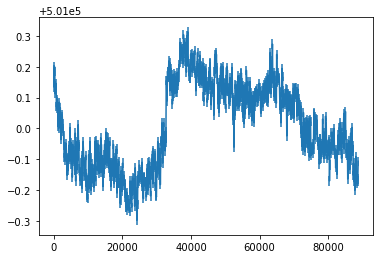

In [9]:
#U0_meas = U0*mean_vnorm_meas
U0_meas = U0+mean_vnorm_meas # actually flat

nuz_meas = itp.omegaz(q, m, U0_meas)/2/np.pi
n_meas = len(nuz_meas)
print(n_meas)
print(n_meas*step_time/60/60)

t = np.arange(0, n_meas)*step_time
plt.errorbar(t, nuz_meas, [15e-3]*n_meas)
plt.show()


93
24.541666666666668


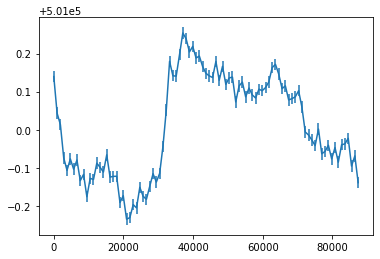

In [10]:
# lets average 10 values and go again
appendix = len(mean_vnorm_meas)%10
vnorm_clip2 = mean_vnorm_meas[:-appendix]

v_norm_re2 = vnorm_clip2.reshape((-1, 10))
#print(v_norm_re)
mean_vnorm_meas2 = np.mean(v_norm_re2, axis=1)
#print(mean_vnorm_meas2)

#U0_meas2 = U0*mean_vnorm_meas2
U0_meas2 = U0+mean_vnorm_meas2 # actually flat

nuz_meas2 = itp.omegaz(q, m, U0_meas2)/2/np.pi
n_meas2 = len(nuz_meas2)
print(n_meas2)
print(n_meas2*step_time*10/60/60)

t2 = np.arange(0, n_meas2)*step_time*10
plt.errorbar(t2, nuz_meas2, [15e-3]*n_meas2)
plt.show()

that does actually look mostly worse than our typical behaviour.... maybe instead of starep data i should
use axial stability data and try to extrapolate to lower times...

<class 'float'>


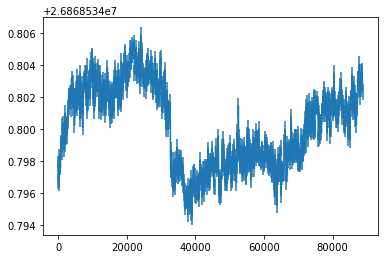

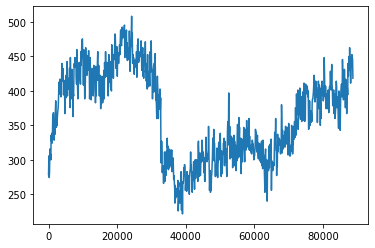

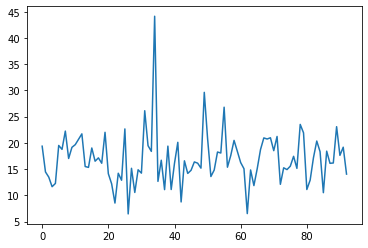

In [11]:
# still lets see how this relates to the cyclotron frequency

omegac = itp.omegac(q, m)


nup = itp.omegap(omegac, nuz_meas*2*np.pi)/2/np.pi
print(type(nup[0]))

plt.errorbar(t, nup, [5e-4]*n_meas)
plt.show()

Nfloat = nup*meas_time
#print(Nfloat)
Nint = np.floor(nup*meas_time)
#print(Nint)

phase = (Nfloat - Nint)*2*np.pi
phase = np.unwrap(phase)*360/2/np.pi
plt.plot(t, phase)
plt.show()

avg_num = 10
appendix = len(phase)%avg_num
phase_clip = phase[:-appendix]

phase_clip = phase_clip.reshape((-1, avg_num))

phase_stds = np.std(phase_clip, axis=1)
plt.plot(phase_stds)
plt.show()

In [12]:
print("mean phase jitter", int(phase_stds.mean()))

mean phase jitter 16


results:
    
    nu res     std Vrel     std Vflat
    740        23           16
    501        10           16